# Assignment 5


### Set up connection to WRDS...

In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import wrds
db=wrds.Connection(wrds_username='tuomas_pkknn')
#db.create_pgpass_file()


Enter your WRDS username [tuomas_pkknn]:tuomas_pkknn
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: n
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [2]:
import statsmodels.api as sm

### Download and format data

In [13]:
#---------------------------------------------
# Risk Free Rate 
#---------------------------------------------
Rf=db.raw_sql("""select  mcaldt,tmytm 
           from crsp.tfz_mth_rf            
            where kytreasnox = 2000001 
           and mcaldt>='1928-01-01'
            and mcaldt<='2014-12-31'""", date_cols=['mcaldt'])
Rf['tmytm']=np.exp(Rf['tmytm']/12/100)-1
Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})


#---------------------------------------------
# Value Weighted Index Returns
#---------------------------------------------
Rm=db.raw_sql("""select  date,vwretd from crsp.msi 
                where date>='1928-01-01' and date<='2014-12-31'
                """,date_cols=['date'])
Rm = Rm.rename(columns={'vwretd':'Rm'})

#---------------------------------------------
# Stock Returns 
#---------------------------------------------
stock_data = db.raw_sql("""
                    select a.permno, a.date, 
                      b.shrcd, b.exchcd,
                      a.ret, a.shrout, a.prc
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1928' and '12/31/2014'
                      and b.exchcd between 1 and 2
                      and b.shrcd between 10 and 11
                      """, date_cols=['date']) 
stock_data=stock_data.drop(['shrcd','exchcd'],axis=1)
stock_data = stock_data.rename(columns={'ret':'Rn'})
stock_data['mcap'] = np.abs(stock_data['prc'])*stock_data['shrout']
stock_data['mcap_l'] = stock_data.groupby(['permno'])['mcap'].shift(1)


#---------------------------------------------
# Merge Data 
#---------------------------------------------
data = pd.merge(stock_data, Rf, on=['date'], how='left')
data = pd.merge(data, Rm, on=['date'], how='left')
# annualize returns
data['const'] = 1
data['Rn_e'] = data['Rn']-data['rf']
data['Rm_e'] = data['Rm']-data['rf']
data['w_m'] = data['mcap_l']/data.groupby(['date'])['mcap_l'].transform('sum')
# Remove nans
data = data.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()
# Remove stocks with less than 60 observations
data['N'] = data.groupby(['permno'])['date'].transform('count')
data = data[data['N']>60].copy()




In [20]:
data['Rn_e'] = data['Rn_e']
data['Rm_e'] = data['Rm_e']
data['Rn'] = data['Rn']
data['Rm'] = data['Rm']
data['rf'] = data['rf']

## Compute Rolling Betas

In [21]:
# (a)
# Define the number of months for the rolling window
rolling_months = 60

# Group by stock and calculate the rolling covariance between excess stock return and excess market return
rolling_covariance = data.groupby('permno')[['Rn_e', 'Rm_e']].rolling(window=rolling_months, min_periods=36).cov()

# Get values for covariances and variances and divide one column by the other
rolling_cov = rolling_covariance['Rm_e'].iloc[::2].values
rolling_var = rolling_covariance['Rm_e'].iloc[1::2].values
rolling_betas = rolling_cov / rolling_var

data['rolling_b'] = rolling_betas
# shift in order to get the right beta for the right return and remove outliers
data['rolling_b'] = data['rolling_b'].shift(-1).clip(data['rolling_b'].quantile(0.05), data['rolling_b'].quantile(0.95))

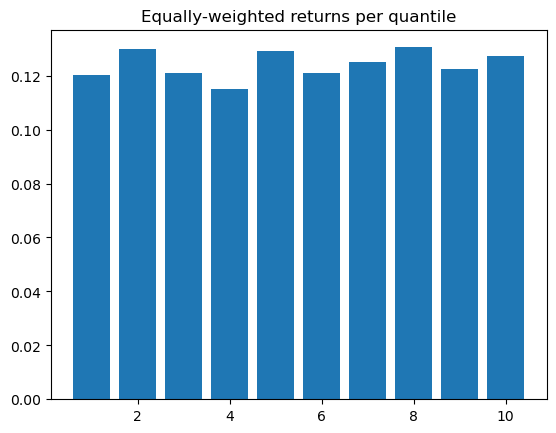

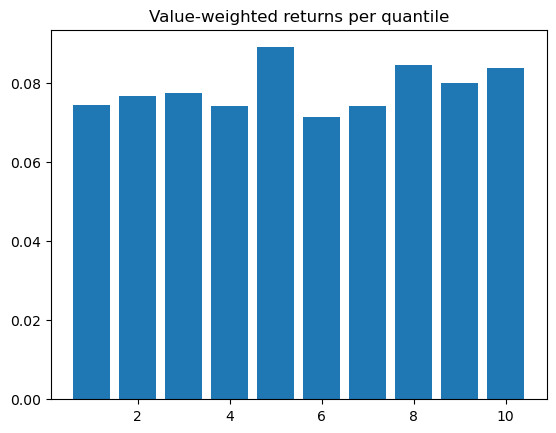

In [23]:
# (b)
# we use the rank to avoid an issue with duplicated edges
data['dec'] = data[['rolling_b', 'date']].groupby('date').transform(lambda q: pd.qcut(q.rank(method='first'), 10, labels=False)) + 1

# equally-weighted
ew_ret = data.groupby(['date', 'dec']).apply(lambda row: (row['Rn_e']).sum()/len(row))
ew_mean_ret = ew_ret.groupby('dec').mean() * 12

x_axis = np.linspace(1, 10, 10)
plt.bar(x_axis, ew_mean_ret)
plt.title("Equally-weighted returns per quantile")
plt.show()

# value-weighted
vw_ret = data.groupby(['date', 'dec']).apply(lambda row: (row['Rn_e'] * row['mcap_l']).sum()/row['mcap_l'].sum())
vw_mean_ret = vw_ret.groupby('dec').mean() * 12

plt.bar(x_axis, vw_mean_ret)
plt.title("Value-weighted returns per quantile")
plt.show()


### Exercise 2b)
The results seem to be pretty much in line due to the addition of the weighted tightness of the funding constraints and the subtraction of it multiplied by the beta.
Thus, the portfolios with lower betas should have lower returns in general (without the additional parameter), however, due to the penalty for a larger beta, the returns should be somehow equivalent for different beta portfolios. This is indeed the case (with slight differences), apart for the 10th quantile of equally-weighted returns, as it seems to be way higher than the others.

In [26]:
# (c)
# rank(beta) = lowest has rank 1
# invert - and + for the R_BAB
data['rank'] = data.groupby('date')['rolling_b'].rank(method='first')
data['z_zavg'] = data['rank'] - data.groupby('date')['rank'].transform('mean')
data['abs_z_z'] = abs(data['z_zavg'])
data['sum_z_z'] = data.groupby('date')['abs_z_z'].transform('sum')

# these are aligned to the betas
data['w_k'] = data['z_zavg'] * 2 / data['sum_z_z']
# these are aligned to the returns
data['w_k_ret'] = data['w_k'].shift(1)

data['w_k_prod'] = data['rolling_b'] * data['w_k']
data['w_k_ret_prod'] = data['Rn_e'] * data['w_k_ret']

# check if something is wrong with the sumproduct since we are not supposed to get w_k for the 60 first months
b_h = data.loc[data['w_k'] > 0].groupby('date')[['w_k_prod']].sum()
b_l = data.loc[data['w_k'] <= 0].groupby('date')[['w_k_prod']].sum()
r_h = data.loc[data['w_k_ret'] > 0].groupby('date')[['w_k_ret_prod']].sum()
r_l = data.loc[data['w_k_ret'] <= 0].groupby('date')[['w_k_ret_prod']].sum()

r_h.columns = ['r_h']
r_l.columns = ['r_l']
b_h.columns = ['b_h']
b_l.columns = ['b_l']

df_sr_temp = pd.merge(r_h, Rf, on='date')
df_sr_temp = pd.merge(df_sr_temp, r_l, on='date')
df_sr_temp = pd.merge(df_sr_temp, b_h, on='date')
df_sr_temp = pd.merge(df_sr_temp, b_l, on='date')
df_sr = pd.merge(df_sr_temp, Rm, on='date')

# inverted, as discussed in the exercise session, annualized
df_sr['r_bab'] = 12*((df_sr['r_l'] - df_sr['rf'])/df_sr['b_l'] - (df_sr['r_h'] - df_sr['rf'])/df_sr['b_h'])

regression = sm.OLS(df_sr["r_bab"], sm.add_constant(12*(df_sr['Rm'] - df_sr['rf'])))
alpha_bab, beta_bab = regression.fit().params
is_vol = regression.fit().resid.std()
sr_bab = (df_sr['r_bab'] - 12*df_sr['rf']).mean()/df_sr['r_bab'].std()

print("The alpha of the BAB factor is {:.3f} and its Sharpe Ratio is {:.3f}".format(alpha_bab, sr_bab))

The alpha of the BAB factor is 0.120 and its Sharpe Ratio is 0.197
1.291849143456796


### Exercise 2d)
Since the returns $R^H$ and $R^L$ are calculated in terms of the actual returns and not the excess returns, the BAB factor return is not dollar neutral in terms of risky securities only, as it holds the risk-free asset.

The difference with the portfolio $R^H - R^L$ is that $R^{BAB}$ standardizes the two separate returns in terms of the risk-free rate and the beta, representing the market risk sensitivity. This means, that the difference is expressed in terms of a common "unit".

$R_{BAB}$ takes into account the difference of the excess return-to-market risk ratios of the low and the high beta portfolios, whereas the other one just takes into account the difference in the pure returns, which does not allow us to compare the actual tradeoffs of the strategy. This reminds us of the utility of the Sharpe Ratio in a market risk setting.

### Exercise 2e)
Given $\alpha$ and $\sigma_I$ as calculated in part c), 

Max Sharpe Ratio $SR_P=\sqrt{SR_M^2+IR^2}$

$IR = \frac{\alpha}{\sigma_I^2}$

The optimal allocation is:

$x_i = \frac{\alpha}{A*\sigma_I^2}$ in the BAB factor,

$x_M = \frac{\mu_M-R_f}{A*\sigma_M^2}$ in the market portfolio and

$x_0 = 1-x_i-x_F$ in the risk-free asset.

$\mu_M$ is the return of the market portfolio, $\sigma_M^2$ is its variance and $A$ is the risk aversion of an investor (we did not use $a$ due to its similarity to $\alpha$ in $\LaTeX$).

In [27]:
# (e)
# We set a to 2 but one could adapt it depending on one's risk aversion
a = 2
x_i = alpha_bab/(a * is_vol**2)
x_M = (df_sr['Rm'] - df_sr['rf']).mean()/(a * df_sr['Rm'].var())
x_0 = 1 - x_i - x_M

print("The optimal allocation is: {:.3f} in the BAB factor, {:.3f} in the market portfolio and {:.3f} in the risk-free asset.".format(x_i, x_M, x_0))

The optimal allocation is: 0.388 in the BAB factor, 1.060 in the market portfolio and -0.448 in the risk-free asset.


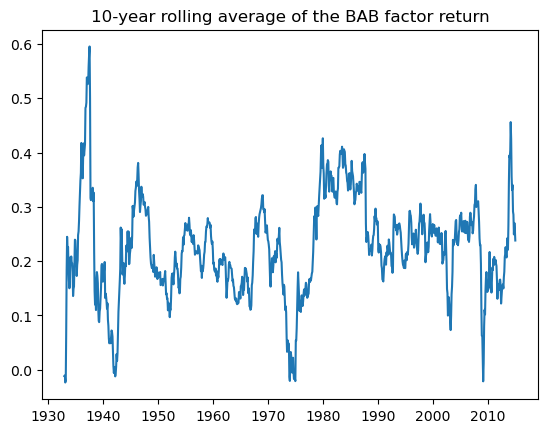

In [28]:
# (f)
df_sr['rolling_avg'] = df_sr['r_bab'].rolling(window=rolling_months).mean()
df_sr_nona = df_sr[['date', 'rolling_avg']].dropna()
plt.plot(df_sr_nona['date'], df_sr_nona['rolling_avg'])
plt.title("10-year rolling average of the BAB factor return")
plt.show()


### Exercise 2f)

The relationship between the average return and the leverage constraint is such that when the constraint is tight (e.g. the investor cannot take on more leverage), the return will be higher, as the investor will take on more risk to reach the target return matching their risk aversion (as the more risky assets often bring in higher returns on average). The BAB return captures this, yielding higher returns during periods of tighter leverage constraints. We would also expect lower returns for the BAB when the leverage constraint is not tight.

Matehmatically speaking, the relationship is linear, as a unit increase in $\psi$ brings an increase/decrease of $1-\beta$ to the return.
